In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# === Load both datasets ===
ids_parallel = [1, 2, 3, 4, 5, 6, 7]
ids_orth     = [1, 2, 5, 6, 7]

dfs_parallel = {i: pd.read_csv(f"halpha results/WB{i}_halpha_results.csv") for i in ids_parallel}
dfs_orth     = {i: pd.read_csv(f"halpha results/WB{i}_orth_halpha_results.csv") for i in ids_orth}

In [3]:
colors = plt.cm.tab10.colors  # 10 distinct colors
color_map = {i: colors[i-1] for i in range(1, 8)}

In [4]:
center_pixels = {
    1: 194,
    2: 189,
    3: 191,
    4: 190,
    5: 185,
    6: 196,
    7: 199,}

center_pixels_orth = {
    1: 190,
    2: 189,
    5: 203,
    6: 189,
    7: 189,}

bar_lengths = {
    1: 2.069913304,
    2: 4.217194803,
    3: 1.96915261,
    4: 3.266140464,
    5: 1.859520678,
    6: 3.899131707,
    7: 2.481995787,
}


In [5]:
def weighted_mean(values, errors, mask):
    vals  = values[mask]
    errs  = errors[mask]
    if np.any(mask) and np.all(errs > 0):
        weights = 1 / errs**2
        mean = np.sum(weights * vals) / np.sum(weights)
        mean_err = np.sqrt(1 / np.sum(weights))
        return mean, mean_err
    return np.nan, np.nan


In [6]:
def summarize_regions(dfs, center_pixels, bar_lengths, take_abs_velocity=True):
    rows = []
    for i, df in dfs.items():
        if i not in center_pixels or i not in bar_lengths:
            continue
        x_rel = (df["center"] - center_pixels[i]) * 0.4  # arcsec
        x_scaled = x_rel / bar_lengths[i]
        abs_x = np.abs(x_scaled)

        center_mask = (abs_x < 0.3)
        bar_mask    = (abs_x >= 0.3) & (abs_x < 0.8)
        out_mask    = (abs_x >= 0.8) & (abs_x <= 1.5)

        vel = np.abs(df["velocity"]) if take_abs_velocity else df["velocity"]

        v_c, v_c_err = weighted_mean(vel, df["velocity_err"], center_mask)
        v_b, v_b_err = weighted_mean(vel, df["velocity_err"], bar_mask)
        v_o, v_o_err = weighted_mean(vel, df["velocity_err"], out_mask)

        s_c, s_c_err = weighted_mean(df["dispersion"], df["dispersion_err"], center_mask)
        s_b, s_b_err = weighted_mean(df["dispersion"], df["dispersion_err"], bar_mask)
        s_o, s_o_err = weighted_mean(df["dispersion"], df["dispersion_err"], out_mask)

        ew_c, ew_c_err = weighted_mean(df["EW"], df["EW_err"], center_mask)
        ew_b, ew_b_err = weighted_mean(df["EW"], df["EW_err"], bar_mask)
        ew_o, ew_o_err = weighted_mean(df["EW"], df["EW_err"], out_mask)

        rows.append({
            "WB": i,
            "v_center": v_c, "v_center_err": v_c_err,
            "v_bar":    v_b, "v_bar_err":    v_b_err,
            "v_out":    v_o, "v_out_err":    v_o_err,
            "σ_center": s_c, "σ_center_err": s_c_err,
            "σ_bar":    s_b, "σ_bar_err":    s_b_err,
            "σ_out":    s_o, "σ_out_err":    s_o_err,
            "EW_center": ew_c, "EW_center_err": ew_c_err,
            "EW_bar":    ew_b, "EW_bar_err":    ew_b_err,
            "EW_out":    ew_o, "EW_out_err":    ew_o_err,
        })
    return pd.DataFrame(rows)


In [7]:
summary_parallel   = summarize_regions(dfs_parallel, center_pixels,      bar_lengths, take_abs_velocity=True)
summary_orthogonal = summarize_regions(dfs_orth,     center_pixels_orth, bar_lengths, take_abs_velocity=True)

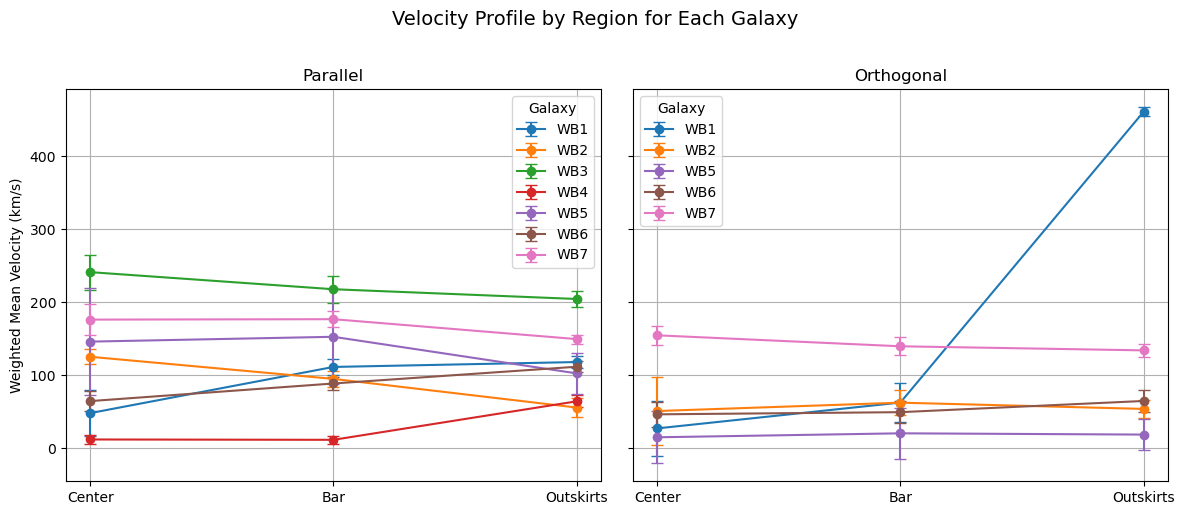

In [8]:
x_labels = ["Center", "Bar", "Outskirts"]
x_pos = np.arange(len(x_labels))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- Left: Parallel ---
for _, row in summary_parallel.iterrows():
    wb_id = int(row["WB"])
    vals  = [row["v_center"], row["v_bar"], row["v_out"]]
    errs  = [row["v_center_err"], row["v_bar_err"], row["v_out_err"]]
    axs[0].errorbar(x_pos, vals, yerr=errs, marker='o', capsize=4,
                    label=f"WB{wb_id}", color=color_map[wb_id])

axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(x_labels)
axs[0].set_ylabel("Weighted Mean Velocity (km/s)")
axs[0].set_title("Parallel")
axs[0].grid(True)
axs[0].legend(title="Galaxy")

# --- Right: Orthogonal ---
for _, row in summary_orthogonal.iterrows():
    wb_id = int(row["WB"])
    vals  = [row["v_center"], row["v_bar"], row["v_out"]]
    errs  = [row["v_center_err"], row["v_bar_err"], row["v_out_err"]]
    axs[1].errorbar(x_pos, vals, yerr=errs, marker='o', capsize=4,
                    label=f"WB{wb_id}", color=color_map[wb_id])

axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(x_labels)
axs[1].set_title("Orthogonal")
axs[1].grid(True)
axs[1].legend(title="Galaxy")

# --- One big title ---
fig.suptitle("Velocity Profile by Region for Each Galaxy", fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


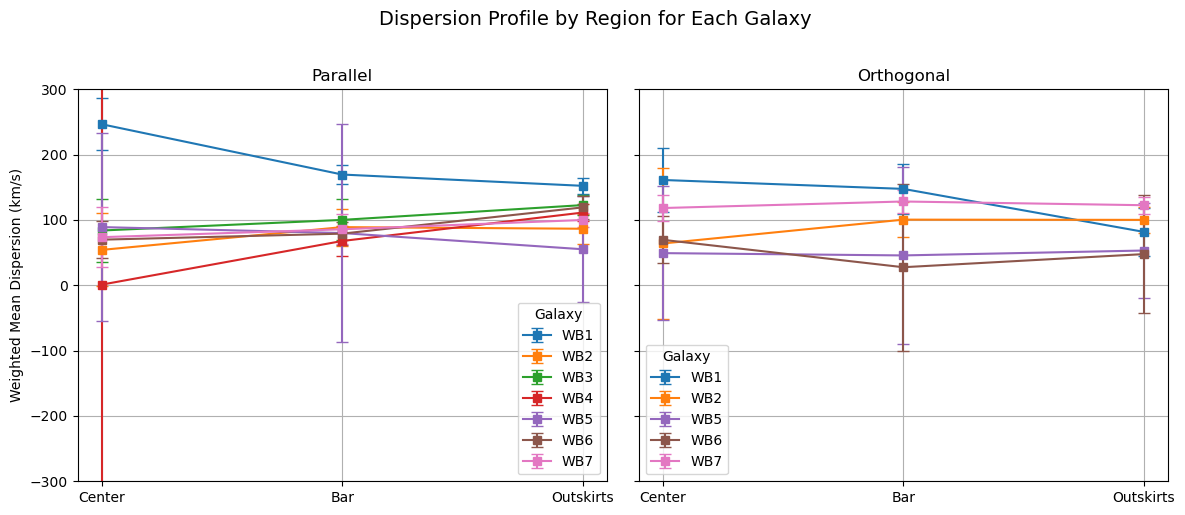

In [9]:
x_labels = ["Center", "Bar", "Outskirts"]
x_pos = np.arange(len(x_labels))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- Left: Parallel ---
for _, row in summary_parallel.iterrows():
    wb_id = int(row["WB"])
    vals  = [row["σ_center"], row["σ_bar"], row["σ_out"]]
    errs  = [row["σ_center_err"], row["σ_bar_err"], row["σ_out_err"]]
    axs[0].errorbar(x_pos, vals, yerr=errs, marker='s', capsize=4,
                    label=f"WB{wb_id}", color=color_map[wb_id])

axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(x_labels)
axs[0].set_ylabel("Weighted Mean Dispersion (km/s)")
axs[0].set_title("Parallel")
axs[0].grid(True)
axs[0].legend(title="Galaxy")

# --- Right: Orthogonal ---
for _, row in summary_orthogonal.iterrows():
    wb_id = int(row["WB"])
    vals  = [row["σ_center"], row["σ_bar"], row["σ_out"]]
    errs  = [row["σ_center_err"], row["σ_bar_err"], row["σ_out_err"]]
    axs[1].errorbar(x_pos, vals, yerr=errs, marker='s', capsize=4,
                    label=f"WB{wb_id}", color=color_map[wb_id])

axs[1].set_ylim(-300,300)
axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(x_labels)
axs[1].set_title("Orthogonal")
axs[1].grid(True)
axs[1].legend(title="Galaxy")

# --- One big title ---
fig.suptitle("Dispersion Profile by Region for Each Galaxy", fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


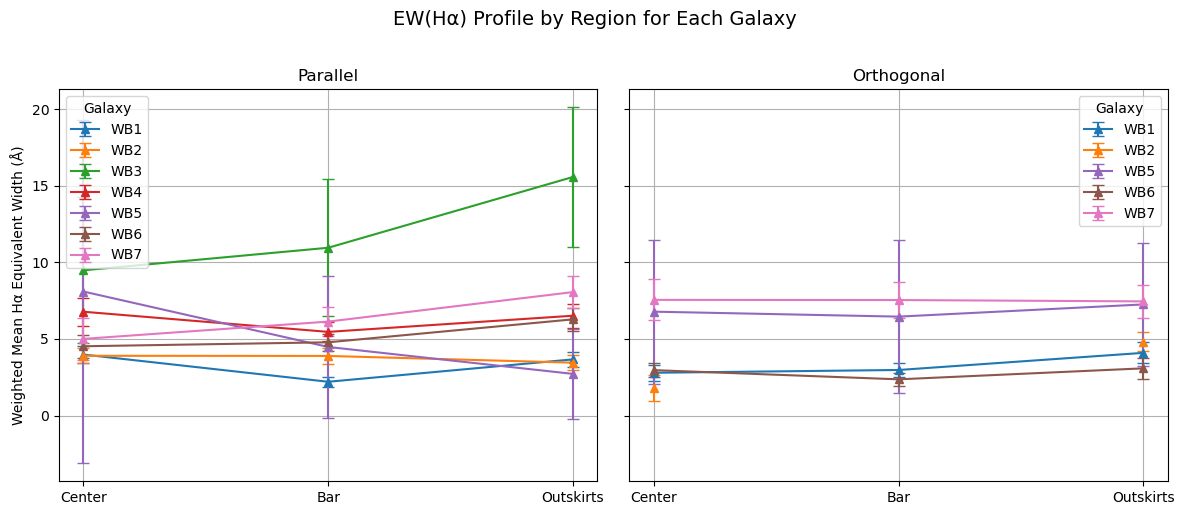

In [10]:
x_labels = ["Center", "Bar", "Outskirts"]
x_pos = np.arange(len(x_labels))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- Left: Parallel ---
for _, row in summary_parallel.iterrows():
    wb_id = int(row["WB"])
    vals  = [row["EW_center"], row["EW_bar"], row["EW_out"]]
    errs  = [row["EW_center_err"], row["EW_bar_err"], row["EW_out_err"]]
    axs[0].errorbar(x_pos, vals, yerr=errs, marker='^', capsize=4,
                    label=f"WB{wb_id}", color=color_map[wb_id])

axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(x_labels)
axs[0].set_ylabel("Weighted Mean Hα Equivalent Width (Å)")
axs[0].set_title("Parallel")
axs[0].grid(True)
axs[0].legend(title="Galaxy")

# --- Right: Orthogonal ---
for _, row in summary_orthogonal.iterrows():
    wb_id = int(row["WB"])
    vals  = [row["EW_center"], row["EW_bar"], row["EW_out"]]
    errs  = [row["EW_center_err"], row["EW_bar_err"], row["EW_out_err"]]
    axs[1].errorbar(x_pos, vals, yerr=errs, marker='^', capsize=4,
                    label=f"WB{wb_id}", color=color_map[wb_id])

axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(x_labels)
axs[1].set_title("Orthogonal")
axs[1].grid(True)
axs[1].legend(title="Galaxy")

# --- One big title ---
fig.suptitle("EW(Hα) Profile by Region for Each Galaxy", fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


In [11]:
# --- Build diff table (parallel − orthogonal), assuming both summaries have same columns ---
diff = summary_parallel.merge(summary_orthogonal, on="WB", suffixes=("_p","_o"))

def diff_cols(prefix):
    v  = f"{prefix}_center"; vb = f"{prefix}_bar"; vo = f"{prefix}_out"
    ve = f"{prefix}_center_err"; vbe = f"{prefix}_bar_err"; voe = f"{prefix}_out_err"
    return [v, vb, vo, ve, vbe, voe]

for pref in ["v", "σ", "EW"]:
    v, vb, vo, ve, vbe, voe = diff_cols(pref)
    diff[v]   = diff[f"{v}_p"]  - diff[f"{v}_o"]
    diff[vb]  = diff[f"{vb}_p"] - diff[f"{vb}_o"]
    diff[vo]  = diff[f"{vo}_p"] - diff[f"{vo}_o"]
    diff[ve]  = np.sqrt(diff[f"{ve}_p"]  ** 2 + diff[f"{ve}_o"]  ** 2)
    diff[vbe] = np.sqrt(diff[f"{vbe}_p"] ** 2 + diff[f"{vbe}_o"] ** 2)
    diff[voe] = np.sqrt(diff[f"{voe}_p"] ** 2 + diff[f"{voe}_o"] ** 2)

summary_diff = diff[["WB",
    "v_center","v_bar","v_out","v_center_err","v_bar_err","v_out_err",
    "σ_center","σ_bar","σ_out","σ_center_err","σ_bar_err","σ_out_err",
    "EW_center","EW_bar","EW_out","EW_center_err","EW_bar_err","EW_out_err"]]


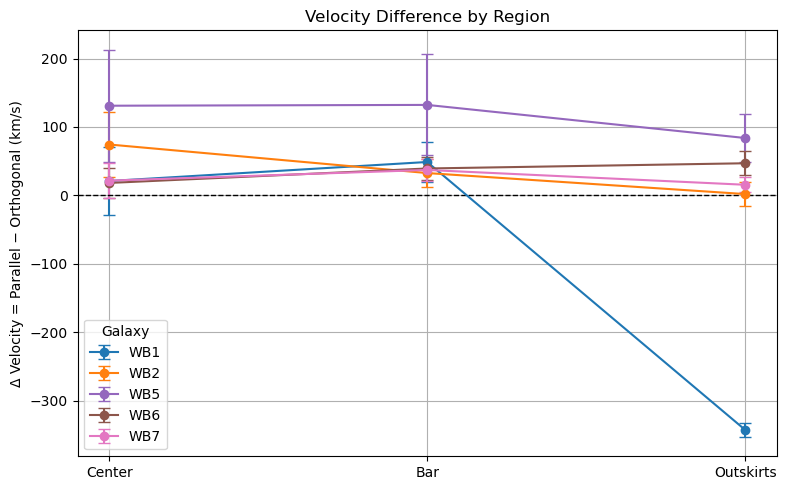

In [12]:
x_labels = ["Center", "Bar", "Outskirts"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots(figsize=(8, 5))
for _, row in summary_diff.iterrows():
    wb = int(row["WB"])
    vals = [row["v_center"], row["v_bar"], row["v_out"]]
    errs = [row["v_center_err"], row["v_bar_err"], row["v_out_err"]]
    ax.errorbar(x_pos, vals, yerr=errs, marker='o', capsize=4,
                label=f"WB{wb}", color=color_map[wb])

ax.axhline(0, ls='--', lw=1, color='black')
ax.set_xticks(x_pos); ax.set_xticklabels(x_labels)
ax.set_ylabel("Δ Velocity = Parallel − Orthogonal (km/s)")
ax.set_title("Velocity Difference by Region")
ax.legend(title="Galaxy"); ax.grid(True)
plt.tight_layout(); plt.show()


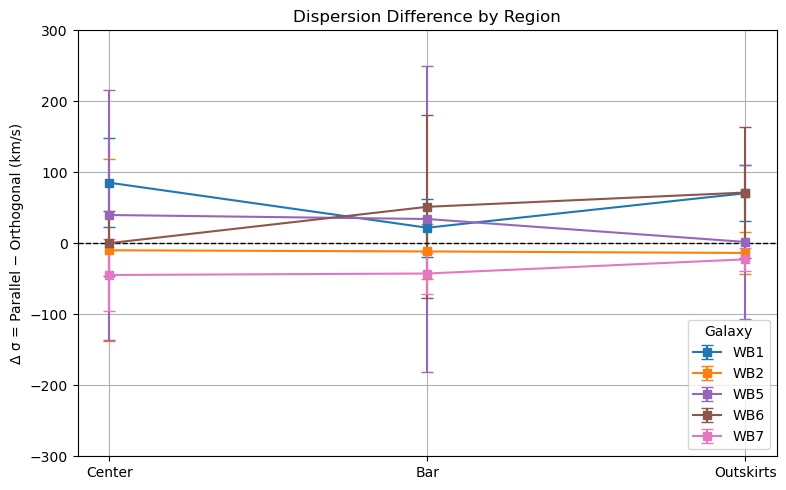

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
for _, row in summary_diff.iterrows():
    wb = int(row["WB"])
    vals = [row["σ_center"], row["σ_bar"], row["σ_out"]]
    errs = [row["σ_center_err"], row["σ_bar_err"], row["σ_out_err"]]
    ax.errorbar(x_pos, vals, yerr=errs, marker='s', capsize=4,
                label=f"WB{wb}", color=color_map[wb])

ax.set_ylim(-300,300)
ax.axhline(0, ls='--', lw=1, color='black')
ax.set_xticks(x_pos); ax.set_xticklabels(x_labels)
ax.set_ylabel("Δ σ = Parallel − Orthogonal (km/s)")
ax.set_title("Dispersion Difference by Region")
ax.legend(title="Galaxy"); ax.grid(True)
plt.tight_layout(); plt.show()


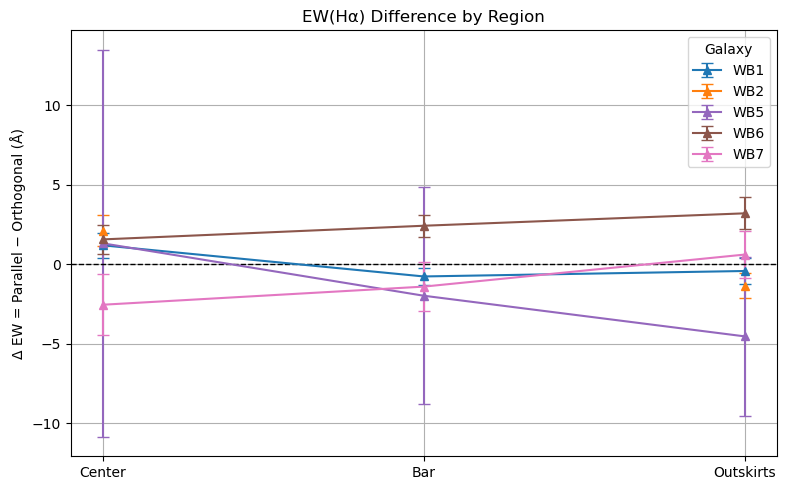

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
for _, row in summary_diff.iterrows():
    wb = int(row["WB"])
    vals = [row["EW_center"], row["EW_bar"], row["EW_out"]]
    errs = [row["EW_center_err"], row["EW_bar_err"], row["EW_out_err"]]
    ax.errorbar(x_pos, vals, yerr=errs, marker='^', capsize=4,
                label=f"WB{wb}", color=color_map[wb])

ax.axhline(0, ls='--', lw=1, color='black')
ax.set_xticks(x_pos); ax.set_xticklabels(x_labels)
ax.set_ylabel("Δ EW = Parallel − Orthogonal (Å)")
ax.set_title("EW(Hα) Difference by Region")
ax.legend(title="Galaxy"); ax.grid(True)
plt.tight_layout(); plt.show()


In [15]:
center_pixels = {
    1: 194,
    2: 189,
    3: 191,
    4: 190,
    5: 191,
    6: 196,
    7: 199,}

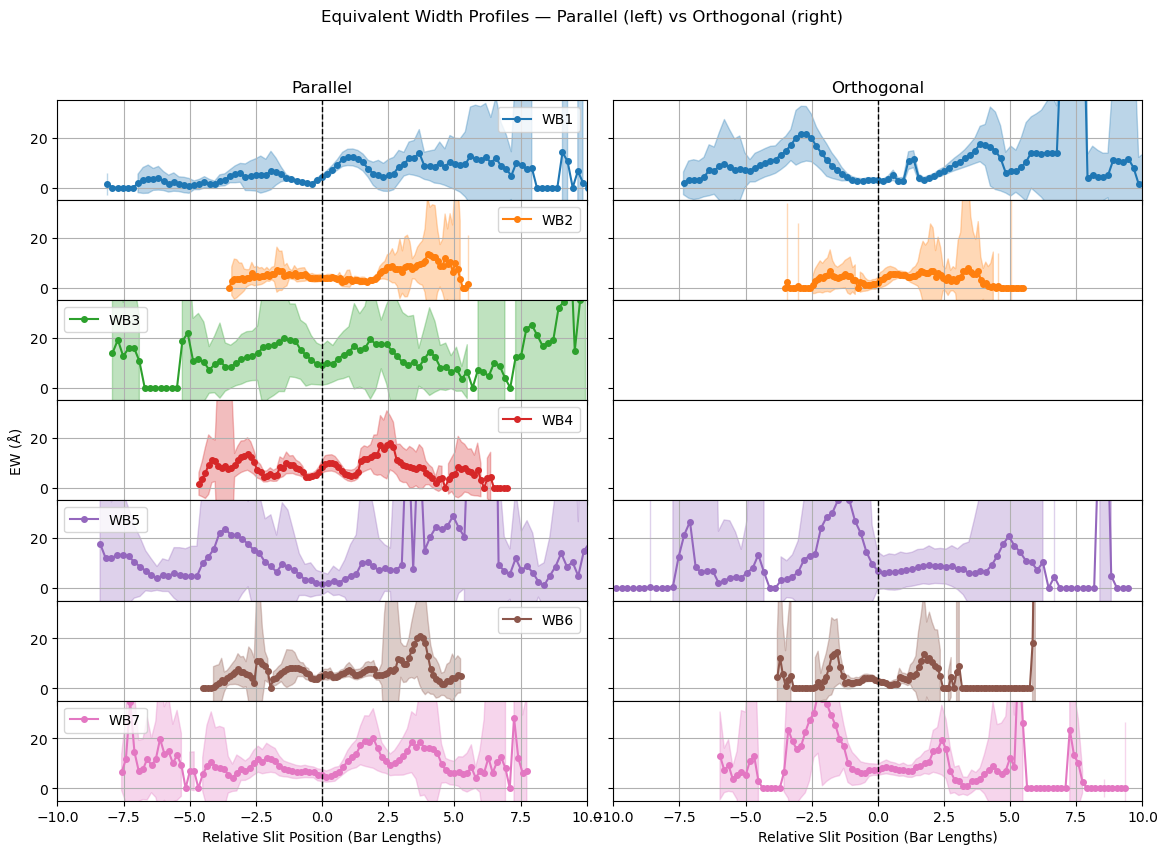

In [19]:
# --- EW ---
fig, axs = plt.subplots(len(dfs_parallel), 2, figsize=(14, 1.3*len(dfs_parallel)), sharex=True, sharey=True)

if len(dfs_parallel) == 1:
    axs = [axs]

for row_idx, i in enumerate(dfs_parallel.keys()):
    # --- Parallel ---
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / bar_lengths[i]

    axs[row_idx, 0].plot(x_scaled_p, df_p["EW"], "o-", color=color_map[i], label=f"WB{i}", ms=4)
    axs[row_idx, 0].fill_between(
        x_scaled_p,
        df_p["EW"] - df_p["EW_err"],
        df_p["EW"] + df_p["EW_err"],
        color=color_map[i], alpha=0.3
    )
    axs[row_idx, 0].set_ylim(-5, 35)
    axs[row_idx, 0].set_xlim(-10, 10)
    axs[row_idx, 0].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx, 0].grid(True)
    axs[row_idx, 0].legend()

    # --- Orthogonal ---
    if i in dfs_orth:
        df_o = dfs_orth[i]
        x_rel_o = (df_o["center"] - center_pixels_orth[i]) * 0.4
        x_scaled_o = x_rel_o / bar_lengths[i]

        axs[row_idx, 1].plot(x_scaled_o, df_o["EW"], "o-", color=color_map[i], ms=4)
        axs[row_idx, 1].fill_between(
            x_scaled_o,
            df_o["EW"] - df_o["EW_err"],
            df_o["EW"] + df_o["EW_err"],
            color=color_map[i], alpha=0.3
        )
        axs[row_idx, 1].set_ylim(-5, 35)
        axs[row_idx, 1].axvline(0, color="black", ls="--", lw=1)
        axs[row_idx, 1].grid(True)

# Labels
for ax in axs[-1, :]:
    ax.set_xlabel("Relative Slit Position (Bar Lengths)")
axs[len(dfs_parallel)//2, 0].set_ylabel("EW (Å)")

axs[0, 0].set_title("Parallel")
axs[0, 1].set_title("Orthogonal")
plt.suptitle("Equivalent Width Profiles — Parallel (left) vs Orthogonal (right)")
plt.subplots_adjust(hspace=0, wspace=0.05)
plt.show()



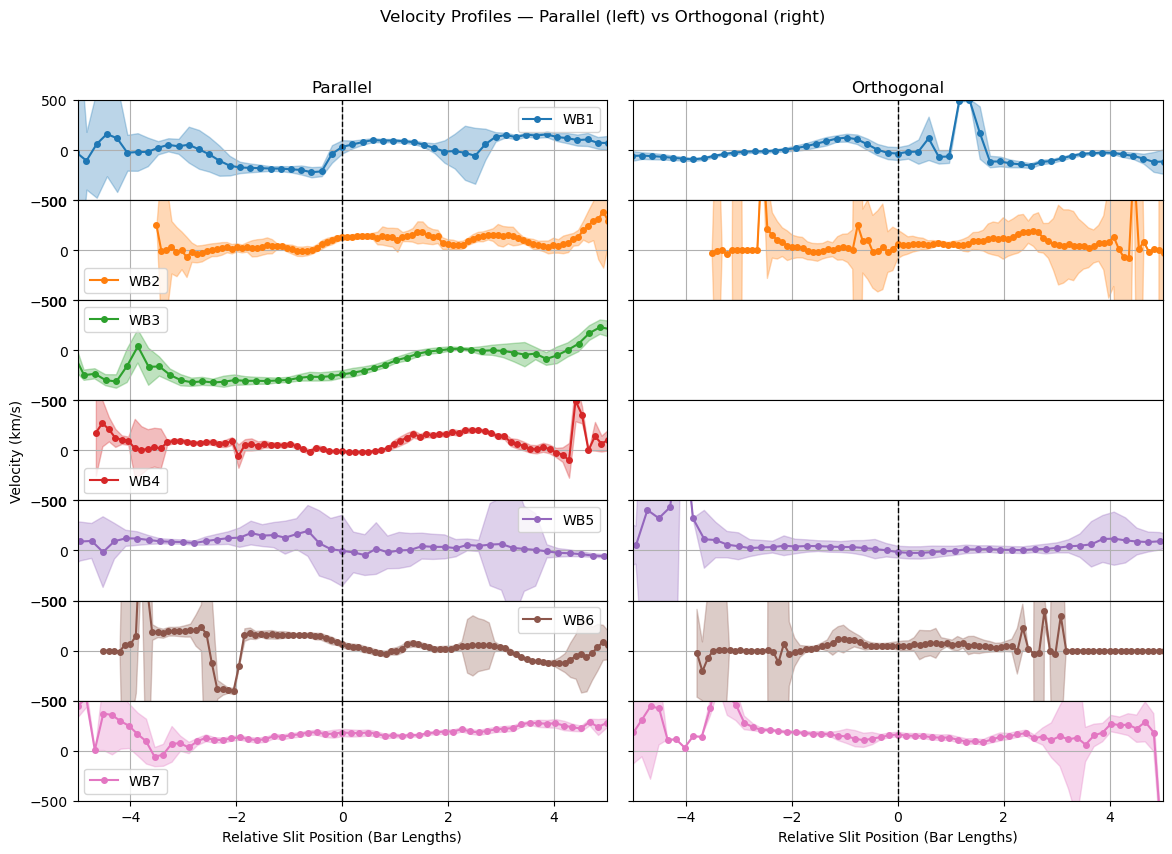

In [17]:
# --- Velocity ---
fig, axs = plt.subplots(len(dfs_parallel), 2, figsize=(14, 1.3*len(dfs_parallel)), sharex=True, sharey=True)

if len(dfs_parallel) == 1:
    axs = [axs]

for row_idx, i in enumerate(dfs_parallel.keys()):
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / bar_lengths[i]

    axs[row_idx, 0].plot(x_scaled_p, df_p["velocity"], "o-", color=color_map[i], label=f"WB{i}", ms=4)
    axs[row_idx, 0].fill_between(
        x_scaled_p,
        df_p["velocity"] - df_p["velocity_err"],
        df_p["velocity"] + df_p["velocity_err"],
        color=color_map[i], alpha=0.3
    )
    axs[row_idx, 0].set_ylim(-400, 400)
    axs[row_idx, 0].set_xlim(-5, 5)
    axs[row_idx, 0].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx, 0].grid(True)
    axs[row_idx, 0].legend()

    if i in dfs_orth:
        df_o = dfs_orth[i]
        x_rel_o = (df_o["center"] - center_pixels_orth[i]) * 0.4
        x_scaled_o = x_rel_o / bar_lengths[i]

        axs[row_idx, 1].plot(x_scaled_o, df_o["velocity"], "o-", color=color_map[i], ms=4)
        axs[row_idx, 1].fill_between(
            x_scaled_o,
            df_o["velocity"] - df_o["velocity_err"],
            df_o["velocity"] + df_o["velocity_err"],
            color=color_map[i], alpha=0.3
        )
        axs[row_idx, 1].axvline(0, color="black", ls="--", lw=1)
        axs[row_idx, 1].grid(True)

for ax in axs[-1, :]:
    ax.set_xlabel("Relative Slit Position (Bar Lengths)")
axs[len(dfs_parallel)//2, 0].set_ylabel("Velocity (km/s)")

axs[0, 0].set_title("Parallel")
axs[0, 1].set_title("Orthogonal")
plt.suptitle("Velocity Profiles — Parallel (left) vs Orthogonal (right)")
plt.subplots_adjust(hspace=0, wspace=0.05)
plt.show()



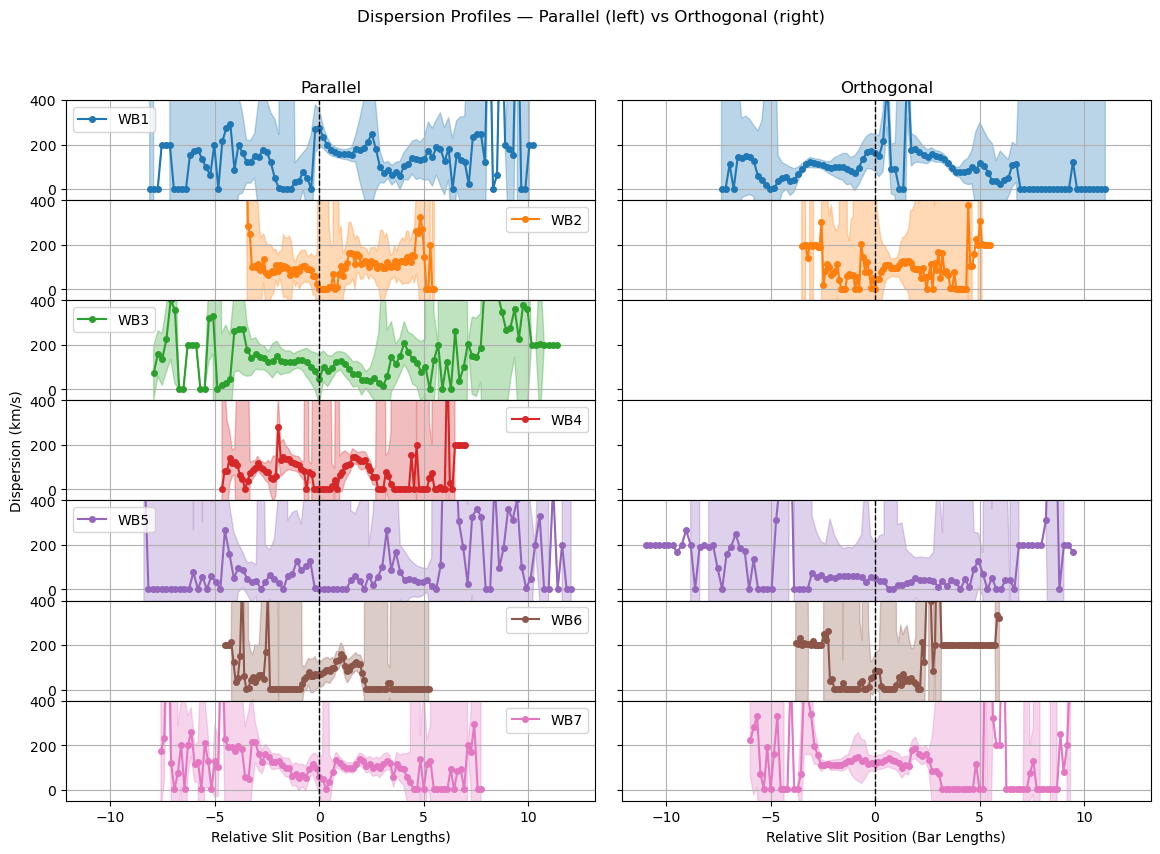

In [18]:
# --- Dispersion ---
fig, axs = plt.subplots(len(dfs_parallel), 2, figsize=(14, 1.3*len(dfs_parallel)), sharex=True, sharey=True)

if len(dfs_parallel) == 1:
    axs = [axs]

for row_idx, i in enumerate(dfs_parallel.keys()):
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / bar_lengths[i]

    axs[row_idx, 0].plot(x_scaled_p, df_p["dispersion"], "o-", color=color_map[i], label=f"WB{i}", ms=4)
    axs[row_idx, 0].fill_between(
        x_scaled_p,
        df_p["dispersion"] - df_p["dispersion_err"],
        df_p["dispersion"] + df_p["dispersion_err"],
        color=color_map[i], alpha=0.3
    )
    axs[row_idx, 0].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx, 0].grid(True)
    axs[row_idx, 0].legend()

    if i in dfs_orth:
        df_o = dfs_orth[i]
        x_rel_o = (df_o["center"] - center_pixels_orth[i]) * 0.4
        x_scaled_o = x_rel_o / bar_lengths[i]

        axs[row_idx, 1].plot(x_scaled_o, df_o["dispersion"], "o-", color=color_map[i], ms=4)
        axs[row_idx, 1].fill_between(
            x_scaled_o,
            df_o["dispersion"] - df_o["dispersion_err"],
            df_o["dispersion"] + df_o["dispersion_err"],
            color=color_map[i], alpha=0.3
        )
        axs[row_idx, 1].set_ylim(-50, 400)
        axs[row_idx, 1].axvline(0, color="black", ls="--", lw=1)
        axs[row_idx, 1].grid(True)

for ax in axs[-1, :]:
    ax.set_xlabel("Relative Slit Position (Bar Lengths)")
axs[len(dfs_parallel)//2, 0].set_ylabel("Dispersion (km/s)")

axs[0, 0].set_title("Parallel")
axs[0, 1].set_title("Orthogonal")
plt.suptitle("Dispersion Profiles — Parallel (left) vs Orthogonal (right)")
plt.subplots_adjust(hspace=0, wspace=0.05)
plt.show()
